In [127]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.widgets as wig
import matplotlib.patches as pat

from dataclasses import dataclass
from enum import Enum
from typing import Type, Tuple, Union
from typing_extensions import Self

%matplotlib widget

In [128]:
REVOLUTE_RADIUS: float = 0.2
REVOLUTE_POTENTIAL_COLOR: str = "gray"
REVOLUTE_FULFILLED_COLOR: str = "green"
REVOLUTE_FULFILLED_ERROR: str = "red"
LINEAR_ELEMENT_COLOR: str = "black"

# close all previouse figure windows
plt.close("all")

In [129]:
Degrees = float

class ArmState(Enum):
    OK = 0
    ERROR = 1

@dataclass
class Frame2D:
    origin: Tuple[float, float]
    orientation: Degrees

@dataclass
class Plotter:
    def update(self, frame: Frame2D):
        raise NotImplementedError

    def error(self):
        raise NotImplementedError

    def recover(self):
        raise NotImplementedError

@dataclass
class Joint:
    def transform(self, frame: Frame2D):
        raise NotImplementedError
    
    def plotter(self, ax: plt.Axes, frame: Frame2D) -> Type[Plotter]:
        raise NotImplementedError

class JointLimitError(Exception):
    pass

### Revolute Joint

In [130]:
@dataclass
class LimitedRevoluteJoint(Joint):
    min: Degrees
    max: Degrees
    rotation: Degrees

    def rotate(self, angle: Degrees) -> Union[Degrees, JointLimitError]:
        if angle < self.min:
            raise JointLimitError(f"input angle {angle:.2f} less than minimum: {self.min:.2f}")
        elif angle > self.max:
            raise JointLimitError(f"input angle {angle:.2f} greater than maximum: {self.max:.2f}")
        else:
            self.rotation = angle
    
    def transform(self, frame: Frame2D):
        return Frame2D(frame.origin, frame.orientation + self.rotation)

    def plotter(self, ax: plt.Axes, frame: Frame2D) -> Type[Plotter]:
        return LimitedRevolutePlot(ax, frame, self)

class LimitedRevolutePlot(Plotter):
    def __init__(
        self,
        ax: plt.Axes,
        frame: Frame2D,
        joint: LimitedRevoluteJoint
    ):
        self.joint = joint

        self.potential_arc = pat.Wedge(
            frame.origin,
            REVOLUTE_RADIUS,
            self.joint.rotation + frame.orientation,
            self.joint.max + frame.orientation,
            color = REVOLUTE_POTENTIAL_COLOR
        )

        self.fulfilled_arc = pat.Wedge(
            frame.origin,
            REVOLUTE_RADIUS,
            self.joint.min + frame.orientation,
            self.joint.rotation + frame.orientation,
            color = REVOLUTE_FULFILLED_COLOR
        )

        ax.add_patch(self.potential_arc)
        ax.add_patch(self.fulfilled_arc)
    
    def update(self, frame: Frame2D):
        self.potential_arc.set_center(frame.origin)
        self.fulfilled_arc.set_center(frame.origin)

        self.potential_arc.set_theta1(self.joint.rotation + frame.orientation)
        self.potential_arc.set_theta2(self.joint.max + frame.orientation)

        self.fulfilled_arc.set_theta1(self.joint.min + frame.orientation)
        self.fulfilled_arc.set_theta2(self.joint.rotation + frame.orientation)

    def error(self):
        self.fulfilled_arc.set_color(REVOLUTE_FULFILLED_ERROR)

    def recover(self):
        self.fulfilled_arc.set_color(REVOLUTE_FULFILLED_COLOR)

### Linear Element

In [131]:
@dataclass
class LinearElement(Joint):
    length: float

    def transform(self, frame: Frame2D):
        naive_offset = np.matrix([[self.length],[0.0]])
        rad = np.radians(frame.orientation)
        cos = np.cos(rad)
        sin = np.sin(rad)
        rotation = np.matrix(
            [[cos, -sin],
             [sin, cos]])
        translation = np.matrix(
            [[frame.origin[0]],
             [frame.origin[1]]])
        result = rotation*naive_offset + translation
        result = np.squeeze(result.tolist())
        return Frame2D((result[0], result[1]), frame.orientation)
    
    def plotter(self, ax: plt.Axes, frame: Frame2D) -> Type[Plotter]:
        return LinearElementPlot(ax, frame, self)

class LinearElementPlot(Plotter):
    def __init__(self, ax: plt.Axes, frame: Frame2D, joint: LinearElement):
        self.joint = joint

        resulting_frame = self.joint.transform(frame)

        self.line = plt.Line2D(
            [frame.origin[0], resulting_frame.origin[0]],
            [frame.origin[1], resulting_frame.origin[1]],
            marker = "o",
            color = LINEAR_ELEMENT_COLOR
        )

        ax.add_line(self.line)
    
    def update(self, frame: Frame2D):
        resulting_frame = self.joint.transform(frame)
        self.line.set_data(
            [frame.origin[0], resulting_frame.origin[0]],
            [frame.origin[1], resulting_frame.origin[1]]
        )


### Plotting

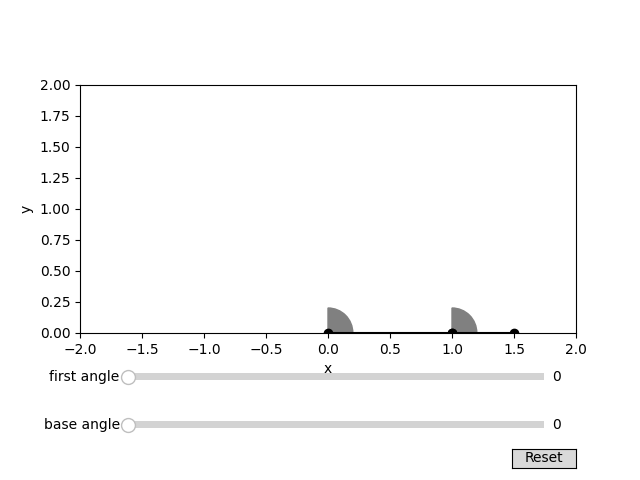

In [132]:
# simple joint
state = ArmState.OK
base = LimitedRevoluteJoint(0.0, 90.0, 0.0)
first = LinearElement(1.0)
second = LimitedRevoluteJoint(0.0, 90.0, 0.0)
third = LinearElement(0.5)

global_origin = (0.0, 0.0)
global_orientation = 0.0
global_frame = Frame2D(
    global_origin,
    global_orientation
)


## setting up the plot
fig, ax = plt.subplots()
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim([-2, 2])
ax.set_ylim([0,2])
ax.set_aspect("equal")

# adjust the main plot to make room for the sliders
fig.subplots_adjust(bottom=0.25)
ax_base = fig.add_axes([0.2, 0.1, 0.65, 0.03])
base_angle = wig.Slider(
    ax=ax_base,
    label='base angle',
    valmin=0.0,
    valmax=180.0,
    valstep=0.1,
    valinit=base.rotation,
)

ax_first_rev = fig.add_axes([0.2, 0.2, 0.65, 0.03])
first_rev_angle = wig.Slider(
    ax=ax_first_rev,
    label='first angle',
    valmin=0.0,
    valmax=180.0,
    valstep=0.1,
    valinit=second.rotation,
)


base_plotter = base.plotter(ax, global_frame)
first_frame = base.transform(global_frame)
first_plotter = first.plotter(ax, first_frame)
second_frame = first.transform(first_frame)
second_plotter = second.plotter(ax, second_frame)
third_frame = second.transform(second_frame)
third_plotter = third.plotter(ax, third_frame)


def update(angle: float):
    global state
    if state == ArmState.ERROR:
        return
    
    try:
        base.rotate(base_angle.val)
    except JointLimitError as error:
        ax.set_title(f"base: {error}", color='red')
        state = ArmState.ERROR
        base_plotter.error()
        fig.canvas.draw_idle()
        return

    try:
        second.rotate(first_rev_angle.val)
    except JointLimitError as error:
        ax.set_title(f"base: {error}", color='red')
        state = ArmState.ERROR
        second_plotter.error()
        fig.canvas.draw_idle()
        return
    
    first_frame = base.transform(global_frame)
    second_frame = first.transform(first_frame)
    third_frame = second.transform(second_frame)

    base_plotter.update(global_frame)
    first_plotter.update(first_frame)
    second_plotter.update(second_frame)
    third_plotter.update(third_frame)

    fig.canvas.draw_idle()

base_angle.on_changed(update)
first_rev_angle.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
button = wig.Button(resetax, 'Reset', hovercolor='0.975')

def reset(event):
    global state
    state = ArmState.OK

    base_plotter.recover()
    second_plotter.recover()
    base_angle.reset()
    first_rev_angle.reset()
    ax.set_title("")


button.on_clicked(reset)

plt.show()